In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from PIL import Image
import os
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [18]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.JPG') or f.endswith('.png') or f.endswith('.tif')]

def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    im = Image.open(filename)
    bm = im.convert('RGB')
    im.close()
    im=bm
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    im.close()
    bm.close()
    resaved_im.close()
    del filename
    del resaved_filename
    del im
    del bm
    del resaved_im
    del extrema
    del max_diff
    del scale
    return ela_im

path_original = '/kaggle/input/casia-dataset/CASIA2/Au/'
path_tampered = '/kaggle/input/casia-dataset/CASIA2/Tp/'

total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

images = []

for file in tqdm(os.listdir(path_original)):
    try:
        if file.endswith('jpg') or file.endswith('JPG') or file.endswith('jpeg') or file.endswith('JPEG'):
            if int(os.stat(path_original + file).st_size) > 10000:
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)

for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        if file.endswith('tif'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
    except:
          print(path_tampered+file)

image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

dataset = pd.DataFrame({'image':image_name,'class_label':label})
dataset.to_csv('dataset_CASIA2.csv',index=False)
dataset = pd.read_csv('dataset_CASIA2.csv')

100%|██████████| 12472/12472 [00:00<00:00, 643412.41it/s]


In [19]:
dataset

,image,class_label
0,/kaggle/input/casia-dataset/CASIA2/Au/Au_pla_3...,0
1,/kaggle/input/casia-dataset/CASIA2/Au/Au_ani_1...,0
2,/kaggle/input/casia-dataset/CASIA2/Au/Au_nat_0...,0
3,/kaggle/input/casia-dataset/CASIA2/Au/Au_nat_3...,0
4,/kaggle/input/casia-dataset/CASIA2/Au/Au_arc_2...,0
...,...,...
12467,/kaggle/input/casia-dataset/CASIA2/Tp/Tp_S_CRN...,1
12468,/kaggle/input/casia-dataset/CASIA2/Tp/Tp_D_NRN...,1
12469,/kaggle/input/casia-dataset/CASIA2/Tp/Tp_S_NNN...,1
12470,/kaggle/input/casia-dataset/CASIA2/Tp/Tp_D_NRN...,1


In [20]:
#del image_name
#del label
#del images
X = []
Y = []
for index, row in tqdm(dataset.iterrows()):
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128),resample=Image.LANCZOS)).flatten() / 255.0)
    Y.append(row[1])
#del dataset

12472it [06:20, 32.80it/s]


In [21]:
#del convert_to_ela_image
XX = np.array(X)
YY = to_categorical(Y, 2)
#del X
#del Y
XX = XX.reshape(-1,128,128, 3)

In [22]:
np.save("pixel_value_array_120",XX)
np.save("label_120",YY)

In [23]:
X_train, X_val, Y_train, Y_val = train_test_split(XX, YY, test_size = 0.2, random_state=5)

In [24]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [26]:
from tensorflow.keras.optimizers import RMSprop

# Define the RMSprop optimizer with the new 'learning_rate' argument
optimizer = RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)


In [27]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [29]:
    from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [30]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [31]:
epochs = 9
batch_size = 100

In [32]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Epoch 1/9
100/100 - 291s - loss: 0.5014 - accuracy: 0.7392 - val_loss: 0.4321 - val_accuracy: 0.7627
Epoch 2/9
100/100 - 289s - loss: 0.3311 - accuracy: 0.8645 - val_loss: 0.2967 - val_accuracy: 0.8862
Epoch 3/9
100/100 - 287s - loss: 0.2653 - accuracy: 0.8882 - val_loss: 0.2854 - val_accuracy: 0.8886
Epoch 4/9
100/100 - 286s - loss: 0.2400 - accuracy: 0.8981 - val_loss: 0.2528 - val_accuracy: 0.8930
Epoch 5/9
100/100 - 286s - loss: 0.2196 - accuracy: 0.9067 - val_loss: 0.3580 - val_accuracy: 0.8549
Epoch 6/9
100/100 - 287s - loss: 0.2009 - accuracy: 0.9122 - val_loss: 0.2861 - val_accuracy: 0.8862
Epoch 7/9
100/100 - 285s - loss: 0.1851 - accuracy: 0.9178 - val_loss: 0.2443 - val_accuracy: 0.8982
Epoch 8/9
100/100 - 285s - loss: 0.1717 - accuracy: 0.9226 - val_loss: 0.2659 - val_accuracy: 0.8758
Epoch 9/9
100/100 - 285s - loss: 0.1584 - accuracy: 0.9286 - val_loss: 0.2927 - val_accuracy: 0.8802


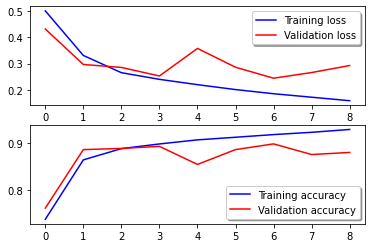

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

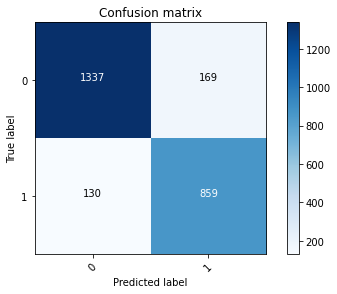

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

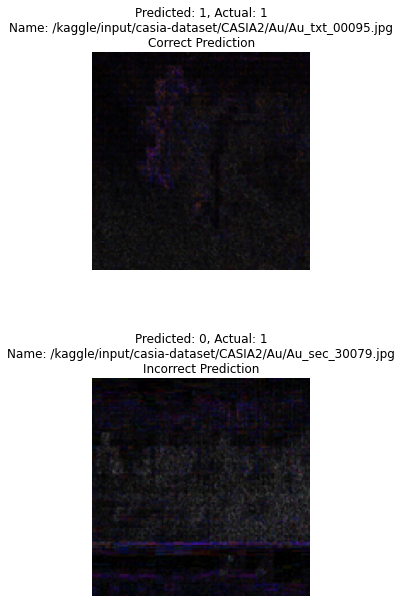

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(X, Y, Y_pred, idx, ax, image_names=None, title=""):
    ax.imshow(X[idx])
    if image_names:
        img_title = f"Predicted: {Y_pred[idx]}, Actual: {Y[idx]}\nName: {image_names[idx]}\n{title}"
    else:
        img_title = f"Predicted: {Y_pred[idx]}, Actual: {Y[idx]}\n{title}"
    ax.set_title(img_title)
    ax.axis('off')

# Assuming image_names is a list of image names corresponding to the images in X
# If not available, set image_names to None

# Find indices of correct and incorrect predictions
correct = np.where(Y_pred_classes == Y_true)[0]
incorrect = np.where(Y_pred_classes != Y_true)[0]

# Randomly choose one sample from each
correct_sample = np.random.choice(correct)
incorrect_sample = np.random.choice(incorrect)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(6, 10))  # Adjusted figure size for vertical spacing

# Adjust vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)  # Increase vertical space between plots

# Plotting a correct prediction
plot_sample(X_val, Y_true, Y_pred_classes, correct_sample, axes[0], image_name, "Correct Prediction")

# Plotting an incorrect prediction
plot_sample(X_val, Y_true, Y_pred_classes, incorrect_sample, axes[1], image_name, "Incorrect Prediction")

plt.show()


In [1]:
# Find indices of different cases
true_positive = np.where((Y_pred_classes == 1) & (Y_true == 1))[0]
false_positive = np.where((Y_pred_classes == 1) & (Y_true == 0))[0]
false_negative = np.where((Y_pred_classes == 0) & (Y_true == 1))[0]
true_negative = np.where((Y_pred_classes == 0) & (Y_true == 0))[0]

# Randomly choose one sample from each case
tp_sample = np.random.choice(true_positive)
fp_sample = np.random.choice(false_positive)
fn_sample = np.random.choice(false_negative)
tn_sample = np.random.choice(true_negative)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid for all cases

# Plotting True Positive
plot_sample(X_val, Y_true, Y_pred_classes, tp_sample, axes[0, 0], image_names, "True Positive")

# Plotting False Positive
plot_sample(X_val, Y_true, Y_pred_classes, fp_sample, axes[0, 1], image_names, "False Positive")

# Plotting False Negative
plot_sample(X_val, Y_true, Y_pred_classes, fn_sample, axes[1, 0], image_names, "False Negative")

# Plotting True Negative
plot_sample(X_val, Y_true, Y_pred_classes, tn_sample, axes[1, 1], image_names, "True Negative")

plt.show()


NameError: name 'np' is not defined